In [3]:
import pandas as pd
import streamlit as st
import sklearn
import numpy as np
import csv
import json
import matplotlib.pyplot as plt

In [20]:
light = pd.read_csv(r"C:\Users\ReneJ\Desktop\Data\2023-04-22_08-09-30\Light.csv")
displayB = pd.read_csv(r"C:\Users\ReneJ\Desktop\Data\2023-04-22_08-09-30\Brightness.csv")
battery = pd.read_csv(r"C:\Users\ReneJ\Desktop\Data\2023-04-22_08-09-30\Battery.csv")
acc = pd.read_csv(r"C:\Users\ReneJ\Desktop\Data\2023-04-22_08-09-30\Accelerometer.csv")
acc


,time,seconds_elapsed,z,y,x
0,1682150970608465200,0.233465,0.000000,0.000000,0.000000
1,1682150970628820200,0.253820,0.036057,0.000488,0.075419
2,1682150970648717800,0.273718,0.036057,0.000488,0.075419
3,1682150970668798500,0.293799,0.201759,0.017155,0.079189
4,1682150970689001000,0.314001,0.230834,0.112412,0.056322
...,...,...,...,...,...
2711309,1682205733488645000,54763.113645,0.483028,-0.013208,0.076902
2711310,1682205733508146000,54763.133146,0.483028,-0.013208,0.076902
2711311,1682205733528592600,54763.153593,0.238130,-0.084304,0.092468
2711312,1682205733548734500,54763.173734,0.055187,-0.117578,0.051740


<Axes: xlabel='time'>

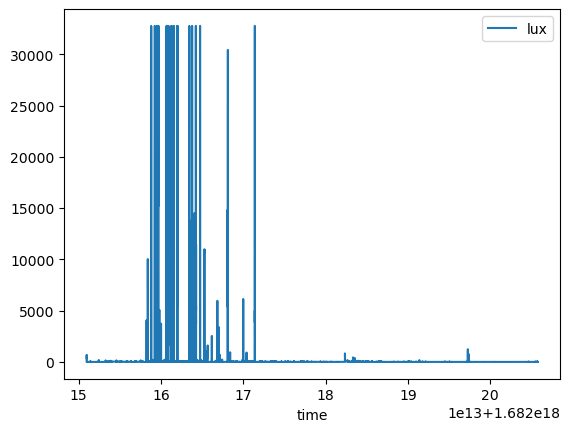

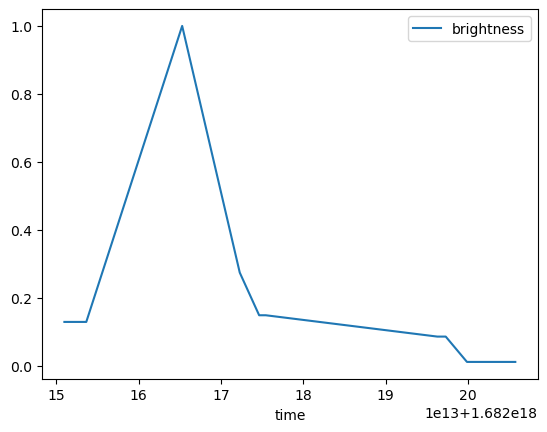

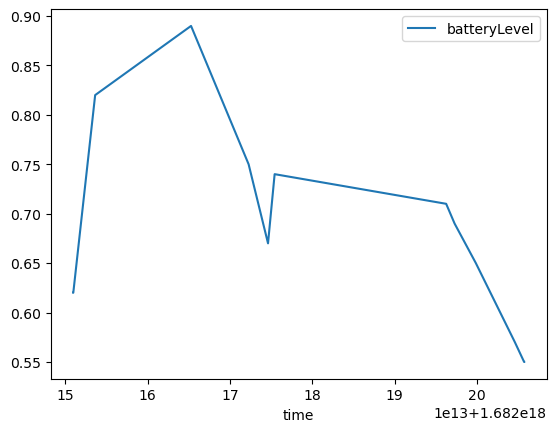

In [19]:
light.plot(x= "time", y = "lux")
displayB.plot(x = "time", y = "brightness")
battery.plot(x = "time", y = "batteryLevel")


<function matplotlib.pyplot.legend(*args, **kwargs)>

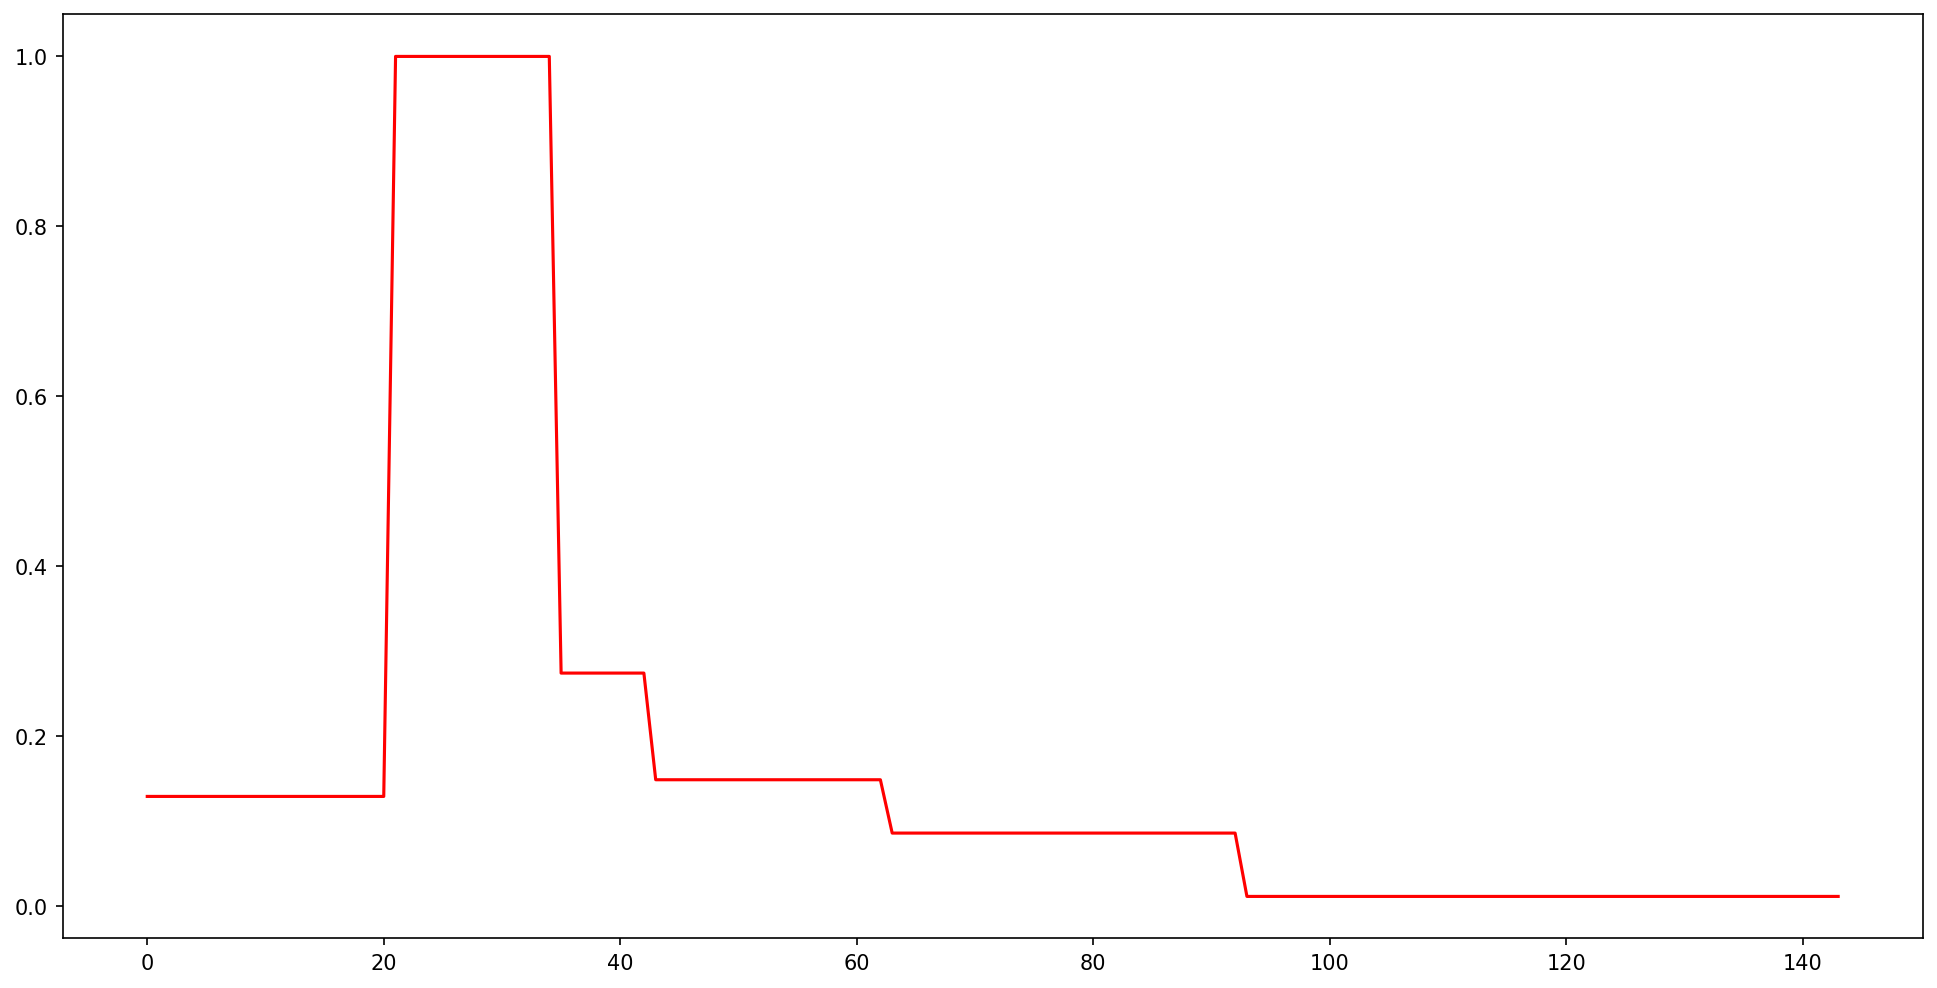

In [15]:
plt.figure(figsize=(16, 8), dpi=150)
#light["lux"].plot(label="Lux", color = "yellow")
displayB["brightness"].plot(label ="Brithness", color = "red")
plt.legend